In [1]:
import numpy as np
import pandas as pd
import utils
from nn import NeuralNetwork
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
def evaluate_classification_metrics(y_true, y_pred, multiclass=False):

    average_type = 'macro' if multiclass else 'binary'

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average_type, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average_type, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average_type, zero_division=0)

    print(f"✅ Accuracy : {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall   : {rec:.4f}")
    print(f"✅ F1 Score : {f1:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }


In [4]:
# Load the dat
train_data = pd.read_csv(
    'data/loan-10k.lrn.csv'
)

train_data.head()


,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 1. Drop ID and extract target
X_df = train_data.drop(columns=["ID", "grade"], errors='ignore')
y = train_data["grade"]

# 2. Clean string-based numeric columns
if 'term' in X_df.columns:
    X_df['term'] = X_df['term'].astype(str).str.extract(r"(\d+)").astype(float)
if 'int_rate' in X_df.columns:
    X_df['int_rate'] = X_df['int_rate'].astype(str).str.rstrip('%').astype(float)
if 'revol_util' in X_df.columns:
    X_df['revol_util'] = X_df['revol_util'].astype(str).str.rstrip('%').astype(float)
if 'emp_length' in X_df.columns:
    emp_map = {
        '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
        '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
        '10+ years': 10
    }
    X_df['emp_length'] = X_df['emp_length'].map(emp_map)

# 3. Drop date columns (heuristically)
date_cols = [col for col in X_df.columns if '_d_' in col or '_year' in col or '_month' in col or 'earliest_cr_line' in col]
X_df.drop(columns=date_cols, inplace=True, errors='ignore')

# 4. Drop high-cardinality categoricals
drop_cols = ['purpose', 'addr_state', 'grade', 'emp_title', 'title', 'zip_code']
for col in drop_cols:
    if col in X_df.columns:
        X_df.drop(columns=col, inplace=True)

# 5. Detect types
num_cols = X_df.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_df.select_dtypes(include='object').columns.tolist()

# 6. Build preprocessing pipelines
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

# 7. Encode target label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y_encoded.reshape(-1, 1))

# 8. Transform features
X_processed = preprocessor.fit_transform(X_df)

# 9. Split
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_onehot, test_size=0.2, random_state=42
)


In [8]:
print(X_train.shape[1])
print(y_train.shape[1])

97
7


In [9]:
configs = [
    # Simple
    {"layers": [X_train.shape[1],y_train.shape[1]], "act": [utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], y_train.shape[1]], "act": [utils.softmax], "lr": 0.1},
    {"layers": [X_train.shape[1], y_train.shape[1]], "act": [utils.softmax], "lr": 1},

    # 1 hidden layer
    {"layers": [X_train.shape[1], 16, y_train.shape[1]], "act": [utils.relu, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, y_train.shape[1]], "act": [utils.tanh, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, y_train.shape[1]], "act": [utils.relu, utils.softmax], "lr": 0.1},
    {"layers": [X_train.shape[1], 16, y_train.shape[1]], "act": [utils.tanh, utils.softmax], "lr": 0.1},
    {"layers": [X_train.shape[1], 16, y_train.shape[1]], "act": [utils.tanh, utils.softmax], "lr": 1},

    # 2 hidden layers
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.relu, utils.relu, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.tanh, utils.relu, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.tanh, utils.tanh, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.relu, utils.relu, utils.softmax], "lr": 0.1},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.tanh, utils.relu, utils.softmax], "lr": 0.1},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.tanh, utils.tanh, utils.softmax], "lr":0.1},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.tanh, utils.tanh, utils.softmax], "lr":1}]


In [10]:
results = []

for i, cfg in enumerate(configs):
    print(f"\n🔁 Running config {i+1}/{len(configs)}")
    print(f"Layers: {cfg['layers']}, Activations: {[fn.__name__ for fn in cfg['act']]}, LR: {cfg['lr']}")

    nn = NeuralNetwork(cfg["layers"], cfg["act"], learning_rate=cfg["lr"],multiclass=True)
    
    # Train including validation set
    nn.train(X_train, y_train, epochs=100, X_val=X_val, y_val=y_val)
    
    # Predict final output
    preds = nn.predict(X_val)  # output: class labels
    y_val_labels = np.argmax(y_val, axis=1)  # one-hot → class index

    metrics = evaluate_classification_metrics(y_val_labels, preds, multiclass=True)

    
    # Get metrics stored during training from the model
    train_loss = nn.history["train_loss"][-1]
    val_loss = nn.history["val_loss"][-1] if nn.history["val_loss"] else None
    train_acc = nn.history["train_acc"][-1]
    val_acc = nn.history["val_acc"][-1] if nn.history["val_acc"] else None

    total_params, total_bytes = nn.model_size(verbose=False)



    results.append({
        "config_id": i + 1,
        "layers": cfg["layers"],
        "activations": [fn.__name__ for fn in cfg["act"]],
        "learning_rate": cfg["lr"],

        # Add train history
        "train_loss": float(train_loss),
        "val_loss": float(val_loss) if val_loss is not None else None,
        "train_acc": float(train_acc),
        "val_acc": float(val_acc) if val_acc is not None else None,
        
        **metrics,

        "num_parameters": total_params,
        "ram_bytes": total_bytes,
        })




🔁 Running config 1/15
Layers: [97, 7], Activations: ['softmax'], LR: 0.01
Epoch 1/100, Loss: 2.2564, Acc: 0.4771, Val Loss: 1.0961, Val Acc: 0.6075
Epoch 2/100, Loss: 0.8913, Acc: 0.6796, Val Loss: 0.7967, Val Acc: 0.6985
Epoch 3/100, Loss: 0.6890, Acc: 0.7416, Val Loss: 0.6938, Val Acc: 0.7350
Epoch 4/100, Loss: 0.6137, Acc: 0.7700, Val Loss: 0.6245, Val Acc: 0.7550
Epoch 5/100, Loss: 0.5645, Acc: 0.7855, Val Loss: 0.6032, Val Acc: 0.7700
Epoch 6/100, Loss: 0.5281, Acc: 0.8013, Val Loss: 0.5787, Val Acc: 0.7750
Epoch 7/100, Loss: 0.5035, Acc: 0.8101, Val Loss: 0.5595, Val Acc: 0.7820
Epoch 8/100, Loss: 0.4845, Acc: 0.8184, Val Loss: 0.5395, Val Acc: 0.7875
Epoch 9/100, Loss: 0.4680, Acc: 0.8233, Val Loss: 0.5344, Val Acc: 0.7920
Epoch 10/100, Loss: 0.4518, Acc: 0.8283, Val Loss: 0.5141, Val Acc: 0.7950
Epoch 11/100, Loss: 0.4447, Acc: 0.8296, Val Loss: 0.5139, Val Acc: 0.7990
Epoch 12/100, Loss: 0.4360, Acc: 0.8331, Val Loss: 0.5053, Val Acc: 0.8025
Epoch 13/100, Loss: 0.4223, Acc: 0

In [11]:
df_results = pd.DataFrame(results)
df_results

,config_id,layers,activations,learning_rate,train_loss,val_loss,train_acc,val_acc,accuracy,precision,recall,f1_score,num_parameters,ram_bytes
0,1,"[97, 7]",[softmax],0.01,0.308096,0.403934,0.875875,0.8445,0.8445,0.752847,0.749266,0.746942,686,5488
1,2,"[97, 7]",[softmax],0.10,1.236083,1.455990,0.837750,0.8155,0.8155,0.704616,0.720066,0.705865,686,5488
2,3,"[97, 7]",[softmax],1.00,4.156629,4.856614,0.826750,0.7990,0.7990,0.694453,0.721824,0.695951,686,5488
3,4,"[97, 16, 7]","[relu, softmax]",0.01,0.305683,0.590962,0.887375,0.8235,0.8235,0.714915,0.688818,0.690651,1687,13496
4,5,"[97, 16, 7]","[tanh, softmax]",0.01,0.252035,0.537882,0.899375,0.8035,0.8035,0.602039,0.610059,0.604904,1687,13496
5,6,"[97, 16, 7]","[relu, softmax]",0.10,1.601408,1.620459,0.292250,0.2940,0.2940,0.113399,0.143345,0.065848,1687,13496
6,7,"[97, 16, 7]","[tanh, softmax]",0.10,0.440075,0.685222,0.839125,0.7945,0.7945,0.606693,0.545574,0.542056,1687,13496
7,8,"[97, 16, 7]","[tanh, softmax]",1.00,6.901350,6.701603,0.523000,0.5120,0.5120,0.403644,0.356392,0.348943,1687,13496
8,9,"[97, 16, 8, 7]","[relu, relu, softmax]",0.01,0.351657,0.535283,0.865000,0.7980,0.7980,0.619035,0.637084,0.606343,1767,14136
9,10,"[97, 16, 8, 7]","[tanh, relu, softmax]",0.01,0.338358,0.577429,0.877375,0.7970,0.7970,0.580596,0.572073,0.565629,1767,14136


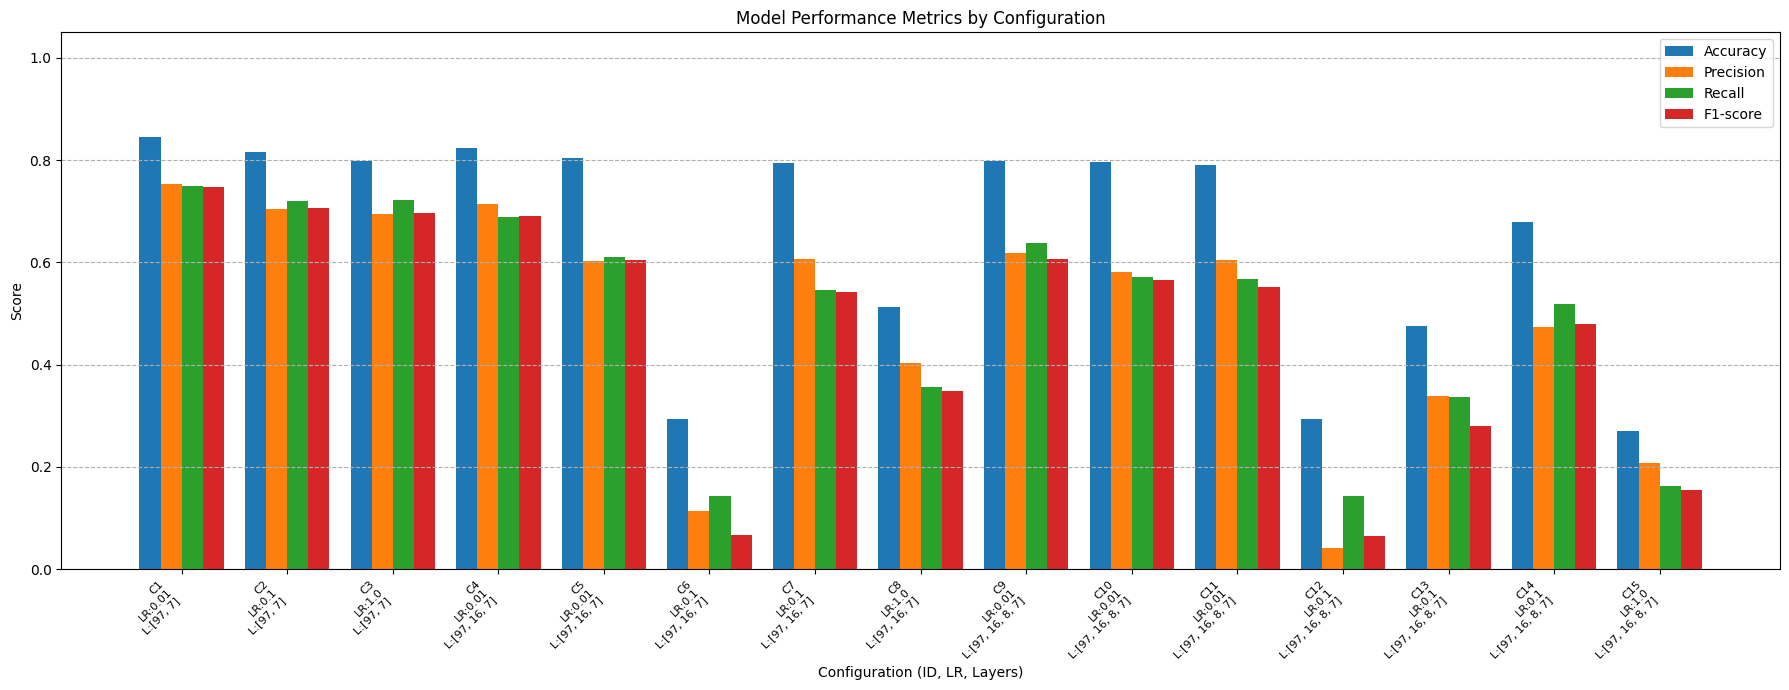

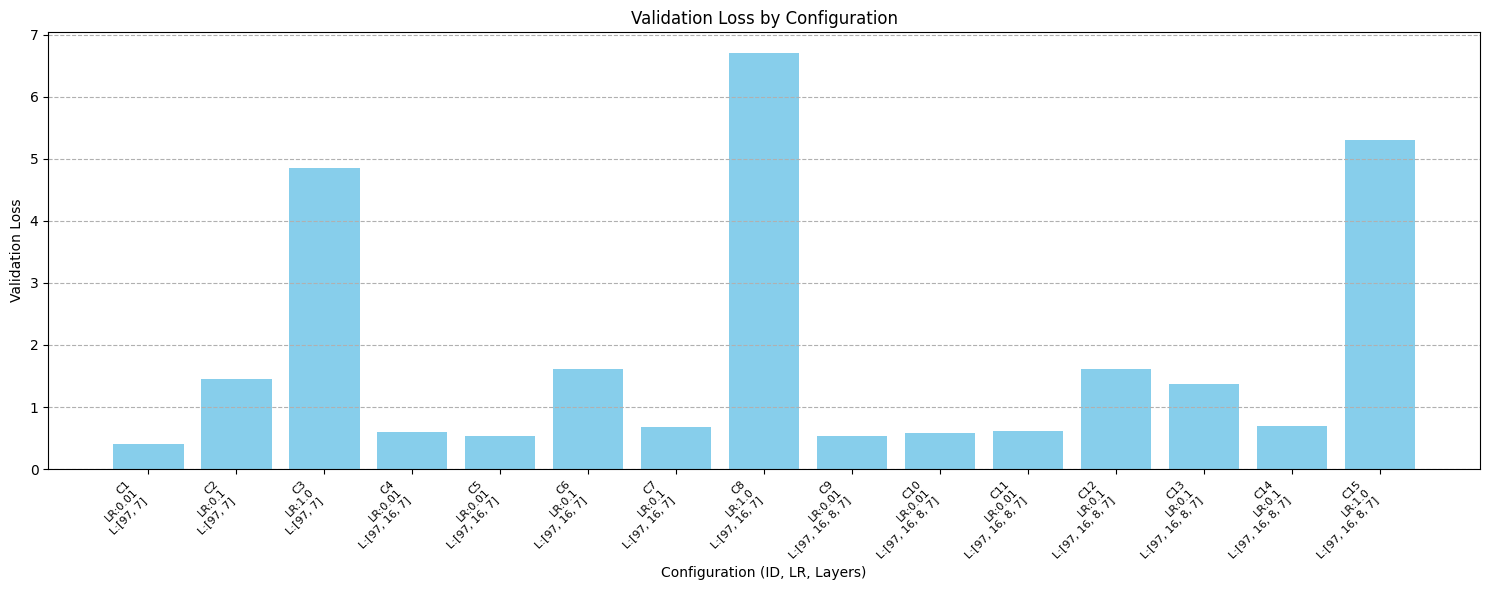

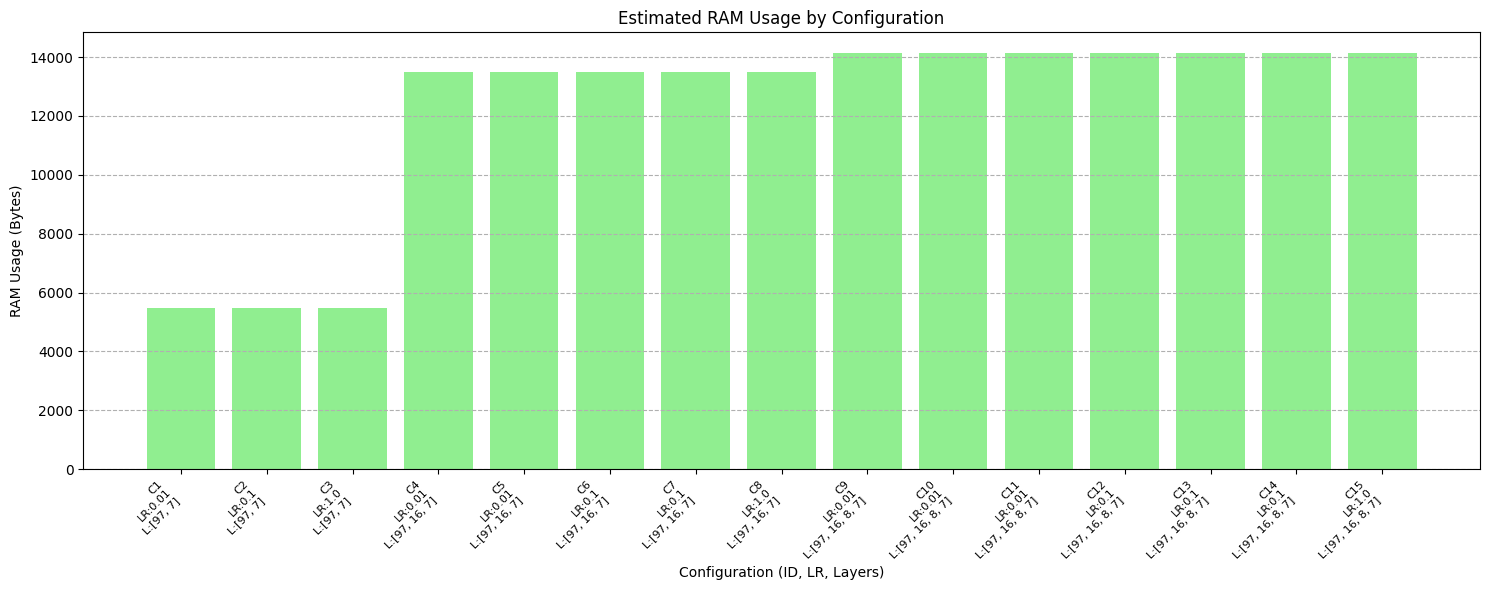

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use your own DataFrame
results_df = df_results.copy()

# Add configuration labels for X-axis
results_df['config_label'] = results_df.apply(
    lambda row: f"C{row['config_id']}\nLR:{row['learning_rate']}\nL:{row['layers']}", axis=1
)

x_labels = results_df['config_label']
x_pos = np.arange(len(x_labels))

# --- Plot 1: Performance Metrics (Accuracy, Precision, Recall, F1-score) ---
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

num_metrics = len(metrics_to_plot)
bar_width = 0.8 / num_metrics

plt.figure(figsize=(18, 7))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x_pos + i * bar_width - (bar_width * (num_metrics - 1) / 2),
            results_df[metric],
            width=bar_width,
            label=metric_names[i])

plt.xlabel("Configuration (ID, LR, Layers)")
plt.ylabel("Score")
plt.title("Model Performance Metrics by Configuration")
plt.xticks(x_pos, x_labels, rotation=45, ha="right", fontsize=8)
plt.legend()
plt.grid(True, axis='y', linestyle='--')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# --- Plot 2: Validation Loss ---
plt.figure(figsize=(15, 6))
plt.bar(x_labels, results_df['val_loss'], color='skyblue')
plt.xlabel("Configuration (ID, LR, Layers)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss by Configuration")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.grid(True, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# --- Plot 3: RAM Usage ---
if 'ram_bytes' in results_df.columns:
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels, results_df['ram_bytes'], color='lightgreen')
    plt.xlabel("Configuration (ID, LR, Layers)")
    plt.ylabel("RAM Usage (Bytes)")
    plt.title("Estimated RAM Usage by Configuration")
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.grid(True, axis='y', linestyle='--')
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No 'ram_bytes' column in results — skipping RAM plot.")
